In [27]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numba
import numba.typed

from pathlib import Path
import glob
import tqdm
import sys
import seaborn as sns
import scipy.stats
import os
import pysam
import pprint
import pickle
import joblib
import subprocess
import io
import itertools
import warnings
import statsmodels.stats.proportion

import polars as pl
pl.Config.set_tbl_rows(-1)
pl.Config.set_fmt_str_lengths(50)


from brokenaxes import brokenaxes
from adjustText import adjust_text


# This is needed before pybedtools to make sure bedtools is imported on sanger JupyterHub 
os.environ["PATH"] += ":" + os.path.join(sys.prefix, "bin")
import pybedtools

pd.set_option('display.max_rows', 1000)


In [3]:
sys.path.append(str(Path(os.getcwd()).parent))
from src import liftover, annotate, diagnostics, inference, contamination
from src.IDs import *


# Add relevant fields to the dataframe of all reads

## Create reads dataframe

In [4]:
rahbari_df = pl.read_csv("/nfs/users/nfs_r/rs42/rs42/git/sperm/configs/Rahbari.tsv", separator='\t')

In [5]:
sudmant_df = pl.read_csv("/nfs/users/nfs_r/rs42/rs42/git/sperm/configs/Sudmant.tsv", separator='\t')

In [6]:
ceph_df = pl.read_csv("/nfs/users/nfs_r/rs42/rs42/git/sperm/configs/CEPH.tsv", separator='\t')

In [6]:
%%time
rahbari_reads_df = pl.concat([
    pl.scan_parquet(
        f"/lustre/scratch122/tol/projects/sperm/results/Rahbari_20250212/read_analysis/{sample_set}/{sample_id}/reads/{chrom}/all_reads_structure_annotated.parquet",
    ) 
    for sample_id, sample_set in tqdm.tqdm(rahbari_df.select("sample_id", "sample_set").unique().iter_rows())
    for chrom in aut_chrom_names
])

9it [00:00, 2808.89it/s]

CPU times: user 9.72 ms, sys: 192 μs, total: 9.92 ms
Wall time: 7.71 ms


In [7]:
%%time
sudmant_reads_df = pl.concat([
    pl.scan_parquet(
        f"/lustre/scratch122/tol/projects/sperm/results/Sudmant_20241121/read_analysis/{sample_set}/{sample_id}/reads/{chrom}/all_reads_structure_annotated.parquet",
    ) 
    for sample_id, sample_set in tqdm.tqdm(sudmant_df.select("sample_id", "sample_set").unique().iter_rows())
    for chrom in aut_chrom_names
])

6it [00:00, 3009.91it/s]

CPU times: user 4.72 ms, sys: 80 μs, total: 4.8 ms
Wall time: 3.48 ms


In [8]:
reads_df = pl.concat([rahbari_reads_df, sudmant_reads_df])

# Basic stats

In [22]:
output_path = Path("/lustre/scratch122/tol/projects/sperm/results/Rahbari_20250212")

panel_snps_df = pl.concat([
    (
        pl.scan_parquet(glob.glob(str(
            output_path / f"alignments/{sample_set}/{sample_id}/{flow_cell}/*/alignment_to_reference_panel.parquet"
        ))).with_columns(
            sample_id=pl.lit(sample_id), 
            flow_cell=pl.lit(flow_cell),
            flow_cell_type=pl.lit(flow_cell_type),        
        )
        .collect(streaming=True)
    )
    for sample_set, sample_id, flow_cell, flow_cell_type, _ in tqdm.tqdm(list(rahbari_df.iter_rows())[:1])
])


100%|██████████| 1/1 [00:13<00:00, 13.61s/it]


In [23]:
%%time
ann_snps_with_panel_df = pl.concat([
    (
        pl.scan_parquet(glob.glob(str(
            output_path / f"alignments/{sample_set}/{sample_id}/{flow_cell}/chr22/alignment_to_reference_panel.parquet"
        ))).join(
            pl.scan_parquet(glob.glob(str(
                output_path / f"read_analysis/{sample_set}/{sample_id}/{flow_cell}/chr22/annotated_0.95_high_confidence_snps.parquet"
            ))),
            on=["read_name", "start"],
            how="full",
        )
        .collect(streaming=False)
    )
    for sample_set, sample_id, flow_cell, flow_cell_type, _ in tqdm.tqdm(list(rahbari_df.iter_rows()))
        if sample_id in ["PD50523b"] and flow_cell in ["m84047_240928_151025_s3"]
])

100%|██████████| 56/56 [00:02<00:00, 25.59it/s]

CPU times: user 5.69 s, sys: 2.27 s, total: 7.96 s
Wall time: 2.19 s


In [27]:
panel_snps_df.head()

read_name,start,ref_start,ref_seq,op,allele_freq,sample_id,flow_cell,flow_cell_type
str,i64,i64,str,i64,f64,str,str,str
"""m84047_240924_113521_s4/142478522/ccs""",3856,11874,"""g""",8,0.05,"""PD50521b""","""m84047_240924_113521_s4""","""revio_unbinned"""
"""m84047_240924_113521_s4/142478522/ccs""",3939,11955,"""G""",7,0.03,"""PD50521b""","""m84047_240924_113521_s4""","""revio_unbinned"""
"""m84047_240924_113521_s4/142478522/ccs""",3965,11981,"""G""",7,0.03,"""PD50521b""","""m84047_240924_113521_s4""","""revio_unbinned"""
"""m84047_240924_113521_s4/142478522/ccs""",4024,12040,"""a""",8,0.79,"""PD50521b""","""m84047_240924_113521_s4""","""revio_unbinned"""
"""m84047_240924_113521_s4/142478522/ccs""",4092,12108,"""G""",7,0.06,"""PD50521b""","""m84047_240924_113521_s4""","""revio_unbinned"""


In [28]:
(ann_snps_with_panel_df
    .filter(
        (pl.col("op1") == 8) & 
        (pl.col("op2") == 8)
    )
    .filter(pl.col("ref_seq").is_null())
    .head()
)

read_name,start,ref_start,ref_seq,op,allele_freq,start_right,end,length,op1,op2,ref1_start,ref1_end,ref1_gap,ref2_start,ref2_end,ref2_gap,cigar_ptr1,cigar_ptr2,read_name_right,read_length1,read_length2,is_forward1,mapq1,ref1_name,qual_start1,refseq_start1,is_forward2,mapq2,ref2_name,qual_start2,refseq_start2,total_mismatches,total_common_insertions,num_common_insertions,num_common_deletions,total_clipping,num_clipping,is_snp,is_two_sided_mismatch,is_interesting_event,is_flanked_event,fits1_more,trf_repeat_length_hap1,trf_n_copies_hap1,trf_repeat_length_hap2,trf_n_copies_hap2,sdust_repeat_length_hap1,sdust_repeat_length_hap2,is_high_conf_event,is_high_conf_snp,is_mid_conf_event,is_mid_conf_snp,hap1_certainty_0.95_coverage,hap2_certainty_0.95_coverage,hap1_total_coverage,hap2_total_coverage,allele_coverage_hap1,allele_coverage_hap2,hap_certainty_0.95_coverage_balance_p,allele_coverage_balance_p,is_high_quality_event,is_high_quality_snp,is_mid_quality_event,is_mid_quality_snp
str,i64,i64,str,i64,f64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,str,i32,i32,bool,i32,str,u8,str,bool,i32,str,u8,str,i64,i64,u32,u32,i64,u32,bool,bool,bool,bool,i32,i64,f64,i64,f64,i32,i32,bool,bool,bool,bool,i64,i64,i64,i64,u32,u32,f64,f64,bool,bool,bool,bool
null,null,null,null,null,null,301,302,1,8,8,7359026,7359027,1,10796865,10796866,1,6,10,"""m84047_240928_151025_s3/172626301/ccs""",5343,5343,false,1,"""chr22_RagTag""",93,"""A""",false,1,"""chr22_RagTag""",93,"""A""",52,0,0,0,6,2,false,true,true,true,0,0,0.0,0,0.0,0,0,false,false,true,false,77,61,133,104,0,0,0.201473,0.0,false,false,false,false
null,null,null,null,null,null,7381,7382,1,8,8,6793705,6793706,1,10274526,10274527,1,42,30,"""m84047_240928_151025_s3/260442400/ccs""",25669,25669,false,4,"""chr22_RagTag""",74,"""A""",false,1,"""chr22_RagTag""",74,"""A""",22,1,1,8,26,2,false,true,true,true,0,171,620.9,171,536.5,0,0,false,false,false,false,0,0,0,0,0,0,1.0,0.0,false,false,false,false
null,null,null,null,null,null,5021,5022,1,8,8,41590148,41590149,1,46203019,46203020,1,74,111,"""m84047_240928_151025_s3/155977361/ccs""",22097,22097,false,60,"""chr22_RagTag""",23,"""C""",false,60,"""chr22_RagTag""",23,"""C""",51,59,58,146,0,0,false,true,true,true,0,0,0.0,0,0.0,0,0,false,false,false,false,68,71,139,139,0,0,0.865374,0.0,false,false,false,false
null,null,null,null,null,null,6976,6977,1,8,8,24715887,24715888,1,29362151,29362152,1,131,147,"""m84047_240928_151025_s3/97062707/ccs""",18261,18261,true,60,"""chr22_RagTag""",7,"""A""",true,60,"""chr22_RagTag""",7,"""A""",25,40,40,82,28,1,false,true,true,true,0,0,0.0,0,0.0,0,0,false,false,false,false,80,72,152,152,0,0,0.570333,0.0,false,false,false,false
null,null,null,null,null,null,8651,8652,1,8,8,19070222,19070223,1,23724820,23724821,1,140,142,"""m84047_240928_151025_s3/123405590/ccs""",14236,14236,true,60,"""chr22_RagTag""",5,"""A""",true,60,"""chr22_RagTag""",5,"""A""",24,38,36,74,8,1,false,true,true,true,0,0,0.0,0,0.0,0,0,false,false,false,false,2,1,3,3,0,0,1.0,0.0,false,false,false,false


In [35]:
(ann_snps_with_panel_df
    .filter(pl.col("is_high_conf_event"))
    .group_by("read_name")
    .agg(
        (
            (pl.col("op1") == 8) & 
            (pl.col("op2") == 8) & 
            pl.col("allele_freq").is_not_null()
        ).sum().alias("n_double_mismatches_at_panel_snps")
    )
    .group_by("n_double_mismatches_at_panel_snps")
    .len()
    .sort("n_double_mismatches_at_panel_snps")
)

n_double_mismatches_at_panel_snps,len
u32,u32
0,43160
1,56
2,17
3,16
4,16
5,8
6,6
7,9
8,4


In [9]:
Adf = (ann_snps_with_panel_df
    .group_by("read_name")
    .agg(
        (
            pl.col("op1").is_null() & 
            pl.col("allele_freq").is_not_null()
        ).sum().alias("n_panel_snps_not_in_read"),
        (            
            pl.col("allele_freq") * pl.col("op1").is_null()
        ).sum().alias("exp_panel_snps_not_in_read"),
        (            
            (1-pl.col("allele_freq")) * pl.col("op1").is_null()
        ).product().alias("prob_panel_snps_not_in_read"),
    )
)

Bdf = (ann_snps_with_panel_df
    .filter(pl.col("is_high_conf_event"))
    .group_by("read_name")
    .agg(
        (
            (pl.col("op1") == 8) & 
            (pl.col("op2") == 8) & 
            pl.col("allele_freq").is_not_null()
        ).sum().alias("n_double_mismatches_at_panel_snps")
    )
)

In [10]:
exp_df = (Adf
    .join(Bdf, on="read_name")
#    .filter(pl.col("n_double_mismatches_at_panel_snps") == 0)
#    .filter(pl.col("n_panel_snps_not_in_read") == 100).head()
    # .group_by("n_panel_snps_not_in_read")
    # .len()
    # .sort("n_panel_snps_not_in_read")
)
    

In [20]:
(ann_snps_with_panel_df
    .group_by("read_name")
    .agg(
        (
            pl.col("op1").is_null() & 
            pl.col("allele_freq").is_not_null()
        ).sum().alias("n_panel_snps_not_in_read"),
        (
            (1-pl.col("allele_freq")) ** pl.col("op1").is_not_null().cast(pl.Int64)
        ).product().alias("prob_panel_snps_not_in_read"),
        
    )
#    .select(pl.col("n_panel_snps_not_in_read") >= 10).mean()
    .filter(pl.col("n_panel_snps_not_in_read") >= 50)
    .select(pl.col("prob_panel_snps_not_in_read")).mean()
)

prob_panel_snps_not_in_read
f64
0.309572


In [22]:
(ann_snps_with_panel_df
    .filter(pl.col("allele_freq").is_null() | (pl.col("allele_freq") >= 0.1))
    .group_by("read_name")
    .agg(
        (
            pl.col("op1").is_null() & 
            pl.col("allele_freq").is_not_null()
        ).sum().alias("n_panel_snps_not_in_read"),
        (
            (1-pl.col("allele_freq")) ** pl.col("op1").is_not_null().cast(pl.Int64)
        ).product().alias("prob_panel_snps_not_in_read"),
        
    )
#    .select(pl.col("n_panel_snps_not_in_read") >= 10).mean()
    .filter(pl.col("n_panel_snps_not_in_read") >= 10)
    .select(pl.col("prob_panel_snps_not_in_read")).mean()
)

prob_panel_snps_not_in_read
f64
0.359005


In [49]:
(ann_snps_with_panel_df
    .filter(pl.col("read_name").is_not_null())
    .filter(pl.col("allele_freq") >= 0.1)
    .group_by("read_name")
    .agg(
        (
            pl.col("op1").is_null() & 
            pl.col("allele_freq").is_not_null()
        ).sum().alias("n_panel_snps_not_in_read"),        
        (1 - pl.col("allele_freq")).product().alias("prob_not_detected")
    )
    .filter(pl.col("n_panel_snps_not_in_read") >= 20) 
    .select(
        (1 - pl.col("prob_not_detected")).alias("prob_detected").mean(),        
    )
)

prob_detected
f64
0.999834


In [50]:
(ann_snps_with_panel_df
    .filter(pl.col("read_name").is_not_null())
    .filter(pl.col("allele_freq") >= 0.1)
    .group_by("read_name")
    .agg(
        (
            pl.col("op1").is_null() & 
            pl.col("allele_freq").is_not_null()
        ).sum().alias("n_panel_snps_not_in_read"),        
        (1 - pl.col("allele_freq")).product().alias("prob_not_detected")
    )
    .select((pl.col("n_panel_snps_not_in_read") >= 20).mean())
)

n_panel_snps_not_in_read
f64
0.386087


In [43]:
Adf = (ann_snps_with_panel_df
    .filter(pl.col("op1").is_null())
    .group_by("read_name")
    .agg(
        (            
            (1-pl.col("allele_freq"))
        ).product().alias("prob_panel_snps_not_in_read"),
    )
)

In [44]:
prob_detection = (1-Adf["prob_panel_snps_not_in_read"])

In [45]:
prob_detection.head()

prob_panel_snps_not_in_read
f64
1.0
1.0
0.920854
0.999994
1.0
0.999909
1.0
1.0
1.0


In [46]:
prob_detection.mean()

0.9263688541994867

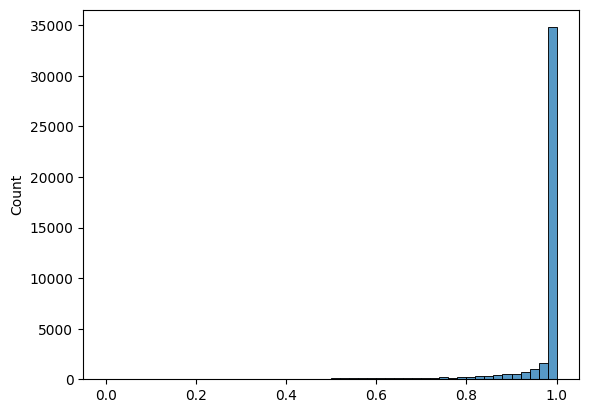

In [26]:
sns.histplot(prob_detection, bins=50);

In [30]:
(prob_detection>0.999).mean()

0.657403988183161

In [31]:
%%time
read_name_to_prob_contamination_detection_df = \
    pl.read_parquet(
        f"/lustre/scratch122/tol/projects/sperm/results/Rahbari_20250212/read_analysis/*/*/*/*/prob_contamination_detection_per_read.parquet"
    )
    

CPU times: user 33.8 s, sys: 17.6 s, total: 51.4 s
Wall time: 1min 4s


In [32]:
read_name_to_prob_contamination_detection_df.head()

read_name,log2_prob_panel_snps_not_in_read
str,f64
"""m64016e_220904_102424/39127528/ccs""",-inf
"""m64016e_220904_102424/721994/ccs""",-0.37707
"""m64016e_220904_102424/55312874/ccs""",-17.487104
"""m64016e_220904_102424/171510464/ccs""",-5.886672
"""m64016e_220904_102424/147589175/ccs""",-inf


In [33]:
prob_detection = (1-2**read_name_to_prob_contamination_detection_df["log2_prob_panel_snps_not_in_read"])

In [34]:
prob_detection.filter(prob_detection.is_not_nan()).mean()

0.9467535565572087

In [36]:
read_name_to_prob_contamination_detection_df["log2_prob_panel_snps_not_in_read"].is_infinite().mean()

0.15706930811885456

In [7]:
sdfs = {}
for sample_set, sample_id, flow_cell, flow_cell_type, _ in tqdm.tqdm(list(rahbari_df.iter_rows())):
    df = pl.read_parquet(
        f"/lustre/scratch122/tol/projects/sperm/results/Rahbari_20250212/read_analysis/{sample_set}/{sample_id}/{flow_cell}/*/double_mismatches_per_read.parquet"
    )
    sdf = (df
        .group_by("n_double_mismatches_at_panel_snps").len()
        .sort("n_double_mismatches_at_panel_snps")
    )
    sdf = (sdf.with_columns(frac = pl.col("len") / sdf["len"].sum()))
    sdfs[(sample_id, flow_cell, flow_cell_type)] = sdf

100%|██████████| 56/56 [00:48<00:00,  1.17it/s]


In [8]:
rows = []
for k in sdfs.keys():
    sample_id, flow_cell, flow_cell_type = k
    x = 100*(1-sdfs[k]["frac"][0])
    rows.append([sample_id, flow_cell, flow_cell_type, f'{x:1.2f}%'])

display(
    pl.DataFrame(
        rows,
        schema=["sample_id", "flow_cell", "flow_cell_type", "percent_contaminating"],
        orient="row",
    )
)

sample_id,flow_cell,flow_cell_type,percent_contaminating
str,str,str,str
"""PD50521b""","""m84047_240924_113521_s4""","""revio_unbinned""","""0.10%"""
"""PD50521b""","""m64178e_240721_224443""","""sequel_ii""","""0.10%"""
"""PD50521b""","""m64229e_220912_125215""","""sequel_ii""","""0.11%"""
"""PD50521b""","""m64016e_220901_135237""","""sequel_ii""","""0.11%"""
"""PD50521b""","""m64229e_220909_150132""","""sequel_ii""","""0.11%"""
"""PD50521e""","""m84093_241004_184906_s3""","""revio_unbinned""","""0.09%"""
"""PD50521e""","""m84093_241004_145012_s1""","""revio_unbinned""","""0.10%"""
"""PD50521e""","""m84098_240926_113650_s3""","""revio_unbinned""","""0.09%"""
"""PD50521e""","""m84093_241004_164937_s2""","""revio_unbinned""","""0.09%"""


In [12]:
sdfs = {}
for sample_set, sample_id, flow_cell, flow_cell_type, _ in tqdm.tqdm(list(ceph_df.iter_rows())):
    df = pl.read_parquet(
        f"/lustre/scratch122/tol/projects/sperm/results/CEPH_20250212/read_analysis/{sample_set}/{sample_id}/{flow_cell}/*/double_mismatches_per_read.parquet"
    )
    sdf = (df
        .group_by("n_double_mismatches_at_panel_snps").len()
        .sort("n_double_mismatches_at_panel_snps")
    )
    sdf = (sdf.with_columns(frac = pl.col("len") / sdf["len"].sum()))
    sdfs[(sample_id, flow_cell, flow_cell_type)] = sdf

100%|██████████| 52/52 [00:07<00:00,  7.13it/s]


In [14]:
rows = []
for k in sdfs.keys():
    sample_id, flow_cell, flow_cell_type = k
    x = 100*(1-sdfs[k]["frac"][0])
    rows.append([sample_id, flow_cell, flow_cell_type, f'{x:1.2f}%'])

display(
    pl.DataFrame(
        rows,
        schema=["sample_id", "flow_cell", "flow_cell_type", "percent_contaminating"],
        orient="row",
    )
    .sort("sample_id", "flow_cell")
)

sample_id,flow_cell,flow_cell_type,percent_contaminating
str,str,str,str
"""200100""","""m84039_230317_185953_s3""","""revio_50""","""0.11%"""
"""200101""","""m84039_230401_021407_s1""","""revio_50""","""0.04%"""
"""200101""","""m84039_230403_233415_s1""","""revio_50""","""0.04%"""
"""200102""","""m84039_230401_024513_s2""","""revio_50""","""0.08%"""
"""200102""","""m84039_230404_000434_s2""","""revio_50""","""0.07%"""
"""200104""","""m84039_230317_200114_s1""","""revio_50""","""0.04%"""
"""200106""","""m84039_230320_213709_s3""","""revio_50""","""0.05%"""
"""NA12877""","""m54329U_230131_182014""","""sequel_ii""","""0.08%"""
"""NA12877""","""m54329U_230202_033258""","""sequel_ii""","""0.07%"""


# Test

In [57]:
alignment_bam_filename = "/lustre/scratch122/tol/projects/sperm/results/Rahbari_20250212/alignments/PD50523b/PD50523b/m84047_240928_151025_s3/grch38_reference/minimap2.sorted.primary_alignments.bam"
reference_panel_vcf_filename = "/lustre/scratch122/tol/projects/sperm/data/references/02.grch38/ALL.wgs.shapeit2_integrated_v1a.GRCh38.20181129.sites.decomposed.normalised.common_snps.vcf.bgz"

# df = contamination.compare_read_to_reference(
#     filename,
#     pop_ref_panel_vcf,
#     "chr22",
#     0, 
#     11000000,
# )
df = contamination.compare_read_to_reference_chrom(
    alignment_bam_filename,
    reference_panel_vcf_filename,
    "chr22",
    chunk_size = 10_000_000,
    n_threads = 16,
)

[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   1 out of   1 | elapsed:   16.3s finished
[Parallel(n_jobs=16)]: Done   2 tasks      | elapsed:  1.8min
[Parallel(n_jobs=16)]: Done   3 out of   6 | elapsed: 13.3min remaining: 13.3min
[Parallel(n_jobs=16)]: Done   4 out of   6 | elapsed: 17.4min remaining:  8.7min
[Parallel(n_jobs=16)]: Done   6 out of   6 | elapsed: 17.8min finished


In [58]:
len(df)

3666843

In [38]:
output_path = Path("/lustre/scratch122/tol/projects/sperm/results/Rahbari_20250212")

ann_snps_df = pl.concat([
    (
        pl.scan_parquet(glob.glob(str(
            output_path / f"read_analysis/{sample_set}/{sample_id}/{flow_cell}/*/annotated_0.95_high_confidence_snps.parquet"
        ))).with_columns(
            sample_id=pl.lit(sample_id), 
            flow_cell=pl.lit(flow_cell),
            flow_cell_type=pl.lit(flow_cell_type),        
        )
        .collect(streaming=True)
    )
    for sample_set, sample_id, flow_cell, flow_cell_type, _ in tqdm.tqdm(list(rahbari_df.iter_rows()))
        if sample_id in ["PD50523b"] and flow_cell in ["m84047_240928_151025_s3"]
])




  0%|          | 0/56 [00:00<?, ?it/s]

 52%|█████▏    | 29/56 [01:08<01:03,  2.35s/it]

 54%|█████▎    | 30/56 [01:08<00:58,  2.25s/it]

 55%|█████▌    | 31/56 [01:09<00:53,  2.12s/it]

 57%|█████▋    | 32/56 [01:09<00:48,  2.03s/it]

 59%|█████▉    | 33/56 [01:09<00:42,  1.83s/it]

 61%|██████    | 34/56 [01:10<00:35,  1.62s/it]

 62%|██████▎   | 35/56 [01:11<00:31,  1.51s/it]

100%|██████████| 56/56 [01:12<00:00,  1.29s/it]


In [39]:
len(ann_snps_df)

69057225

In [62]:
%%time
sdf = (ann_snps_df
    .join(
        df.select("read_name", "start", pl.col("op").alias("ref_panel_op"), "allele_freq"),
        on=["read_name", "start"],
        how="full",
    )
    .with_columns(
        is_in_ref_panel = pl.col("allele_freq").is_not_null(),
        is_in_read = pl.col("op1").is_not_null(),
    )
    .group_by("read_name")
    .agg(
        (pl.col("is_in_read") & (pl.col("op1") == pl.col("op2")) & pl.col("is_in_ref_panel")).sum().alias("n_double_mismatches_in_ref_panel"),
        (pl.col("is_in_read") & (pl.col("op1") == pl.col("op2")) & ~pl.col("is_in_ref_panel")).sum().alias("n_double_mismatches_not_in_ref_panel"),
        (~pl.col("is_in_read") & pl.col("is_in_ref_panel")).sum().alias("n_
)

CPU times: user 1min 9s, sys: 56.5 s, total: 2min 6s
Wall time: 22.7 s


In [67]:
(sdf
    .group_by("n_double_mismatches_in_ref_panel").len()
    .sort("n_double_mismatches_in_ref_panel")
)

n_double_mismatches_in_ref_panel,len
u32,u32
0,4845516
1,269
2,24
3,10
4,17
5,14
6,10
7,12
8,7


In [66]:
(sdf
    .group_by("n_double_mismatches_hot_in_ref_panel").len()
)

n_double_mismatches_hot_in_ref_panel,len
u32,u32
42,23
0,3905549
3,104728
15,1441
21,271
45,9
39,35
6,29259
30,51


In [64]:
len(sdf)

4845937

In [40]:
ann_snps_df.head()

start,end,length,op1,op2,ref1_start,ref1_end,ref1_gap,ref2_start,ref2_end,ref2_gap,cigar_ptr1,cigar_ptr2,read_name,read_length1,read_length2,is_forward1,mapq1,ref1_name,qual_start1,refseq_start1,is_forward2,mapq2,ref2_name,qual_start2,refseq_start2,total_mismatches,total_common_insertions,num_common_insertions,num_common_deletions,total_clipping,num_clipping,is_snp,is_two_sided_mismatch,is_interesting_event,is_flanked_event,fits1_more,trf_repeat_length_hap1,trf_n_copies_hap1,trf_repeat_length_hap2,trf_n_copies_hap2,sdust_repeat_length_hap1,sdust_repeat_length_hap2,is_high_conf_event,is_high_conf_snp,is_mid_conf_event,is_mid_conf_snp,hap1_certainty_0.95_coverage,hap2_certainty_0.95_coverage,hap1_total_coverage,hap2_total_coverage,allele_coverage_hap1,allele_coverage_hap2,hap_certainty_0.95_coverage_balance_p,allele_coverage_balance_p,is_high_quality_event,is_high_quality_snp,is_mid_quality_event,is_mid_quality_snp,sample_id,flow_cell,flow_cell_type
i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,str,i32,i32,bool,i32,str,u8,str,bool,i32,str,u8,str,i64,i64,u32,u32,i64,u32,bool,bool,bool,bool,i32,i64,f64,i64,f64,i32,i32,bool,bool,bool,bool,i64,i64,i64,i64,u32,u32,f64,f64,bool,bool,bool,bool,str,str,str
2043,2044,1,7,8,114538532,114538533,1,114820850,114820851,1,0,3,"""m84047_240928_151025_s3/89981482/ccs""",16700,16700,true,60,"""chr5_RagTag""",74,"""C""",true,60,"""chr5_RagTag""",74,"""T""",0,3,3,4,2,1,true,false,true,true,1,0,0.0,0,0.0,0,0,true,true,true,true,85,87,173,172,76,75,0.93925,1.0,false,false,false,false,"""PD50523b""","""m84047_240928_151025_s3""","""revio_unbinned"""
2371,2372,1,7,8,114538860,114538861,1,114821178,114821179,1,0,5,"""m84047_240928_151025_s3/89981482/ccs""",16700,16700,true,60,"""chr5_RagTag""",65,"""C""",true,60,"""chr5_RagTag""",65,"""T""",0,3,3,4,2,1,true,false,true,true,1,0,0.0,0,0.0,0,0,true,true,true,true,86,86,172,173,87,81,1.0,0.699797,false,false,false,false,"""PD50523b""","""m84047_240928_151025_s3""","""revio_unbinned"""
3513,3514,1,7,8,114540003,114540004,1,114822321,114822322,1,2,9,"""m84047_240928_151025_s3/89981482/ccs""",16700,16700,true,60,"""chr5_RagTag""",93,"""C""",true,60,"""chr5_RagTag""",93,"""T""",0,3,3,4,2,1,true,false,true,true,1,0,0.0,0,0.0,0,0,true,true,true,true,88,83,172,172,89,79,0.759794,0.487567,true,true,true,true,"""PD50523b""","""m84047_240928_151025_s3""","""revio_unbinned"""
3656,3657,1,7,8,114540147,114540148,1,114822465,114822466,1,4,13,"""m84047_240928_151025_s3/89981482/ccs""",16700,16700,true,60,"""chr5_RagTag""",60,"""C""",true,60,"""chr5_RagTag""",60,"""A""",0,3,3,4,2,1,true,false,true,true,1,0,0.0,0,0.0,0,0,true,true,true,true,89,83,173,173,84,77,0.703139,0.636446,true,true,true,true,"""PD50523b""","""m84047_240928_151025_s3""","""revio_unbinned"""
3913,3914,1,7,8,114540404,114540405,1,114822722,114822723,1,4,15,"""m84047_240928_151025_s3/89981482/ccs""",16700,16700,true,60,"""chr5_RagTag""",34,"""C""",true,60,"""chr5_RagTag""",34,"""A""",0,3,3,4,2,1,true,false,true,true,1,0,0.0,0,0.0,0,0,false,false,true,true,86,82,169,168,86,76,0.817046,0.479615,false,false,false,false,"""PD50523b""","""m84047_240928_151025_s3""","""revio_unbinned"""


In [51]:
(ann_snps_df
    .filter(pl.col("read_name") == "m84047_240928_151025_s3/143659111/ccs")
)

start,end,length,op1,op2,ref1_start,ref1_end,ref1_gap,ref2_start,ref2_end,ref2_gap,cigar_ptr1,cigar_ptr2,read_name,read_length1,read_length2,is_forward1,mapq1,ref1_name,qual_start1,refseq_start1,is_forward2,mapq2,ref2_name,qual_start2,refseq_start2,total_mismatches,total_common_insertions,num_common_insertions,num_common_deletions,total_clipping,num_clipping,is_snp,is_two_sided_mismatch,is_interesting_event,is_flanked_event,fits1_more,trf_repeat_length_hap1,trf_n_copies_hap1,trf_repeat_length_hap2,trf_n_copies_hap2,sdust_repeat_length_hap1,sdust_repeat_length_hap2,is_high_conf_event,is_high_conf_snp,is_mid_conf_event,is_mid_conf_snp,hap1_certainty_0.95_coverage,hap2_certainty_0.95_coverage,hap1_total_coverage,hap2_total_coverage,allele_coverage_hap1,allele_coverage_hap2,hap_certainty_0.95_coverage_balance_p,allele_coverage_balance_p,is_high_quality_event,is_high_quality_snp,is_mid_quality_event,is_mid_quality_snp,sample_id,flow_cell,flow_cell_type
i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,str,i32,i32,bool,i32,str,u8,str,bool,i32,str,u8,str,i64,i64,u32,u32,i64,u32,bool,bool,bool,bool,i32,i64,f64,i64,f64,i32,i32,bool,bool,bool,bool,i64,i64,i64,i64,u32,u32,f64,f64,bool,bool,bool,bool,str,str,str
434,435,1,7,8,22985234,22985235,1,27631588,27631589,1,0,3,"""m84047_240928_151025_s3/143659111/ccs""",5695,5695,false,60,"""chr22_RagTag""",60,"""T""",false,60,"""chr22_RagTag""",60,"""C""",0,1,1,14,0,0,true,false,true,true,1,0,0.0,0,0.0,0,0,true,true,true,true,59,55,114,114,58,50,0.778876,0.500766,true,true,true,true,"""PD50523b""","""m84047_240928_151025_s3""","""revio_unbinned"""
1027,1028,1,7,8,22985833,22985834,1,27632187,27632188,1,12,17,"""m84047_240928_151025_s3/143659111/ccs""",5695,5695,false,60,"""chr22_RagTag""",50,"""T""",false,60,"""chr22_RagTag""",50,"""C""",0,1,1,14,0,0,true,false,true,true,1,0,0.0,0,0.0,0,0,false,false,true,true,62,56,118,118,61,53,0.645497,0.512255,false,false,true,true,"""PD50523b""","""m84047_240928_151025_s3""","""revio_unbinned"""
1947,1948,1,7,8,22986756,22986757,1,27633108,27633109,1,18,25,"""m84047_240928_151025_s3/143659111/ccs""",5695,5695,false,60,"""chr22_RagTag""",77,"""T""",false,60,"""chr22_RagTag""",77,"""C""",0,1,1,14,0,0,true,false,true,true,1,0,0.0,0,0.0,0,0,true,true,true,true,61,61,122,122,58,55,1.0,0.85087,true,true,true,true,"""PD50523b""","""m84047_240928_151025_s3""","""revio_unbinned"""
2184,2185,1,7,8,22986993,22986994,1,27633344,27633345,1,22,31,"""m84047_240928_151025_s3/143659111/ccs""",5695,5695,false,60,"""chr22_RagTag""",36,"""G""",false,60,"""chr22_RagTag""",36,"""A""",0,1,1,14,0,0,true,false,true,true,1,0,0.0,0,0.0,0,0,false,false,true,true,63,62,125,125,64,59,1.0,0.718509,false,false,true,true,"""PD50523b""","""m84047_240928_151025_s3""","""revio_unbinned"""
3063,3064,1,7,8,22987874,22987875,1,27634222,27634223,1,26,37,"""m84047_240928_151025_s3/143659111/ccs""",5695,5695,false,60,"""chr22_RagTag""",38,"""T""",false,60,"""chr22_RagTag""",38,"""C""",0,1,1,14,0,0,true,false,true,true,1,0,0.0,0,0.0,0,1,false,false,false,false,62,60,122,121,61,58,0.927911,0.85463,false,false,false,false,"""PD50523b""","""m84047_240928_151025_s3""","""revio_unbinned"""
4472,4473,1,7,8,22989286,22989287,1,27635643,27635644,1,34,49,"""m84047_240928_151025_s3/143659111/ccs""",5695,5695,false,60,"""chr22_RagTag""",63,"""A""",false,60,"""chr22_RagTag""",63,"""G""",0,1,1,14,0,0,true,false,true,true,1,0,0.0,0,0.0,0,0,true,true,true,true,57,59,116,116,57,58,0.926078,1.0,true,true,true,true,"""PD50523b""","""m84047_240928_151025_s3""","""revio_unbinned"""
4824,4825,1,7,8,22989638,22989639,1,27635995,27635996,1,34,51,"""m84047_240928_151025_s3/143659111/ccs""",5695,5695,false,60,"""chr22_RagTag""",35,"""G""",false,60,"""chr22_RagTag""",35,"""C""",0,1,1,14,0,0,true,false,true,true,1,0,0.0,0,0.0,0,0,false,false,true,true,60,57,116,116,57,55,0.853408,0.924775,false,false,true,true,"""PD50523b""","""m84047_240928_151025_s3""","""revio_unbinned"""


In [59]:
(df
    .filter(pl.col("read_name") == "m84047_240928_151025_s3/143659111/ccs")
)

read_name,start,ref_start,ref_seq,op,allele_freq
str,i64,i64,str,i64,f64
"""m84047_240928_151025_s3/143659111/ccs""",97,29494076,"""T""",7,0.07
"""m84047_240928_151025_s3/143659111/ccs""",230,29494209,"""G""",7,0.02
"""m84047_240928_151025_s3/143659111/ccs""",368,29494347,"""C""",7,0.09
"""m84047_240928_151025_s3/143659111/ccs""",371,29494350,"""G""",7,0.09
"""m84047_240928_151025_s3/143659111/ccs""",434,29494413,"""T""",7,0.85
"""m84047_240928_151025_s3/143659111/ccs""",1027,29495012,"""T""",7,0.85
"""m84047_240928_151025_s3/143659111/ccs""",1208,29495193,"""G""",7,0.01
"""m84047_240928_151025_s3/143659111/ccs""",1299,29495284,"""C""",7,0.09
"""m84047_240928_151025_s3/143659111/ccs""",1574,29495560,"""T""",7,0.07


In [46]:
(df
    .unique(subset=["read_name"]).head()
)

read_name,start,ref_start,ref_seq,op,allele_freq
str,i64,i64,str,i64,f64
"""m84047_240928_151025_s3/198706180/ccs""",270,32951338,"""G""",7,0.02
"""m84047_240928_151025_s3/50009431/ccs""",79,31771027,"""C""",7,0.01
"""m84047_240928_151025_s3/213127919/ccs""",105,17519777,"""G""",7,0.11
"""m84047_240928_151025_s3/168955871/ccs""",797,28245146,"""A""",7,0.26
"""m84047_240928_151025_s3/143659111/ccs""",98,29494077,"""G""",7,0.07


In [53]:
bam = pysam.AlignmentFile(alignment_bam_filename)

In [55]:
for aln in tqdm.tqdm(bam.fetch("chr22", 29494077, 29494077+50000)):
    if aln.query_name == "m84047_240928_151025_s3/143659111/ccs":
        break



0it [00:00, ?it/s]

21it [00:00, 29.44it/s] 


In [56]:
aln

<AlignedSegment('m84047_240928_151025_s3/143659111/ccs', flags=16=0x10, ref='chr22', zpos=29493979, mapq=60, cigar='569=1D199=1D95=1D117=1D11=1D7=1D385=1D301=1D142=1D121=1X94=1I1=1X60=1D79=1X646=2I202=1D208=1D1135=1D45=2D577=1D650=1X21=1X22=', ...)>

# Sample variants

In [19]:
output_path = Path("/lustre/scratch122/tol/projects/sperm/results/CEPH_20250212")

all_sample_variants_df = pl.read_parquet([
    str(output_path / f"alignments/{chrom}/grch38_variants_on_chrom_at_mid_quality_events.parquet") \
        for chrom in aut_chrom_names
])

In [20]:
sdf = (all_sample_variants_df
    .group_by("n_times")
    .len()
    .sort("n_times")
)

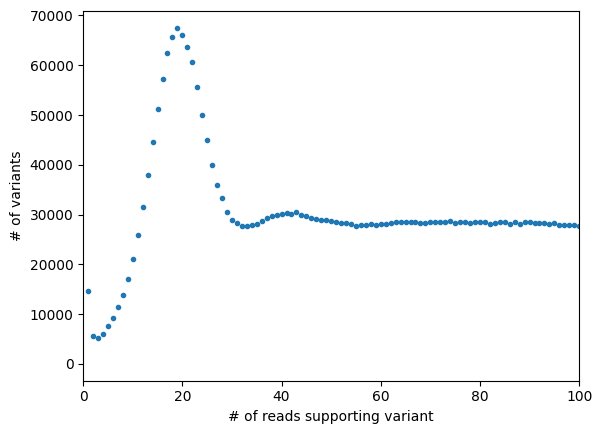

In [23]:
plt.plot(
    sdf["n_times"],
    sdf["len"],
    '.',
);
plt.xlabel("# of reads supporting variant");
plt.ylabel("# of variants");
plt.xlim(0,100);

In [24]:
len(all_sample_variants_df)

4961887

In [25]:
sdf.head()

n_times,len
u32,u32
1,14743
2,5572
3,5146
4,6045
5,7559


In [60]:
%%time
cdf = pl.read_parquet(
    "/lustre/scratch122/tol/projects/sperm/results/CEPH_20250212/read_analysis/*/*/*/*/double_mismatches_per_read_sample_panel.parquet"
)

CPU times: user 14.1 s, sys: 6.22 s, total: 20.3 s
Wall time: 42.7 s


In [61]:
%%time
tdf = pl.read_parquet(
    "/lustre/scratch122/tol/projects/sperm/results/CEPH_20250212/read_analysis/*/*/*/*/double_mismatches_per_read.parquet"
)

CPU times: user 15.4 s, sys: 7.09 s, total: 22.5 s
Wall time: 51.7 s


In [62]:
%%time
jdf = (cdf
    .join(
        tdf,
        on="read_name",
        how="full",
    )
    .fill_null(0)
)

CPU times: user 1min 10s, sys: 24.7 s, total: 1min 35s
Wall time: 50.6 s


In [63]:
len(jdf)

108474165

In [1]:
cdf.head()

NameError: name 'cdf' is not defined

In [64]:
jdf.select(
    ((pl.col("n_double_mismatches_at_panel_snps") >= 1).mean()*100).alias("percent"),
    (pl.col("n_double_mismatches_at_panel_snps") >= 1).sum().alias("sum"),
)

percent,sum
f64,u32
0.659945,715870


In [65]:
jdf.select(
    ((pl.col("n_double_mismatches_at_sample_panel_snps") >= 1).mean()*100).alias("percent"),
    (pl.col("n_double_mismatches_at_sample_panel_snps") >= 1).sum().alias("sum"),
)


percent,sum
f64,u32
0.220037,238683


In [66]:
jdf.select(
    (((pl.col("n_double_mismatches_at_sample_panel_snps") >= 1) | (pl.col("n_double_mismatches_at_panel_snps") >= 1)).mean()*100).alias("percent"),
    ((pl.col("n_double_mismatches_at_sample_panel_snps") >= 1) | (pl.col("n_double_mismatches_at_panel_snps") >= 1)).sum().alias("sum"),
)



percent,sum
f64,u32
0.715432,776059
